# Project 5 - Vehicle Detection and Tracking
## General Project Pipeline
1. Feature extraction and experimentation
2. Choose and train a classifier
3. Implement sliding window technique to search for vehicles on each frame
4. Implement pipeline on video and implement tracking

## Feature Extraction
### Feature Extraction Steps:
For this project, HOG is used as primary features to be extracted.
1. Read in data
2. Use alogrithm provided in lesson to extract HOG
3. Store data into array

#### Read in Data

In [1]:
#imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import os
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.ndimage.measurements import label 

In [7]:
#read in data and create appropriate labels
#obtain training data from each subfolders
car_imgs = glob.glob('./Train_data/vehicles/*/*.png')
noncar_imgs = glob.glob('./Train_data/non-vehicles/*/*.png')

# car_imgs = []
# noncar_imgs = []
# for folder in car_folders:
#     filenames = glob.glob(folder+'/*.png')
#     car_imgs +=  filenames
# for folder in noncar_folders:
#     filenames = glob.glob(folder+'/*.png')
#     noncar_imgs += filenames
    
#print(car_imgs)
print('number of car imgs: ' + str(len(car_imgs)))
print('number of noncar imgs: ' + str(len(noncar_imgs)))

number of car imgs: 8792
number of noncar imgs: 8968


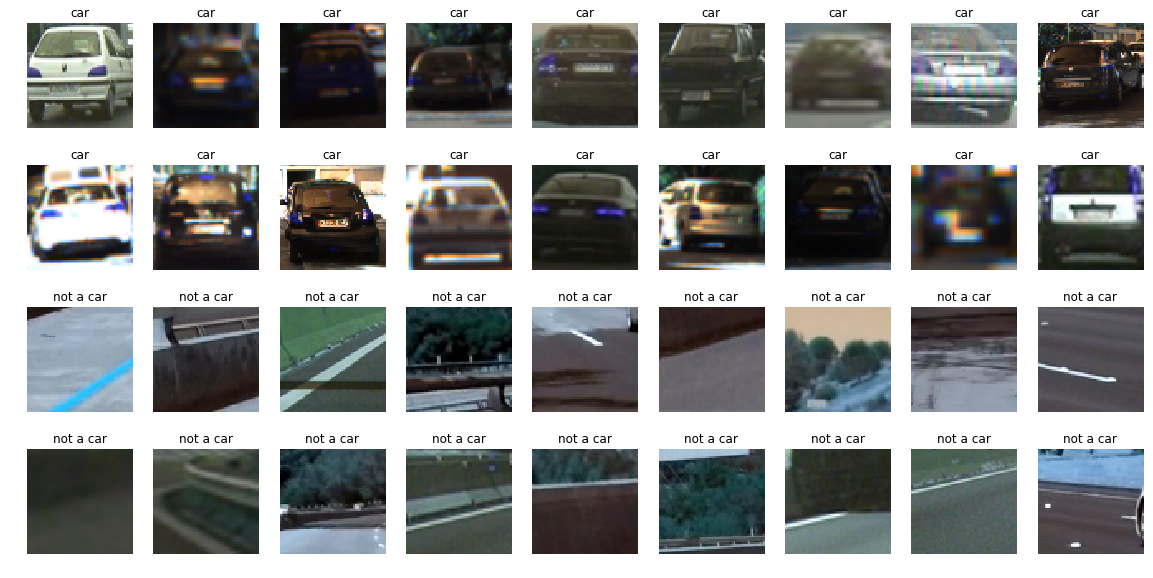

In [8]:
#sample first 18 of each car and non car to visualize
fig, ax = plt.subplots(4,9,figsize=(20,10))
rand = np.random.randint(0,len(car_imgs)-1,size=(18,))
for i in range(len(rand)):
    car_sample = cv2.imread(car_imgs[rand[i]])
    ax.flat[i].imshow(car_sample)
    ax.flat[i].axis('off')
    ax.flat[i].set_title(label='car',loc='center')
for i in range(len(rand)):
    noncar_sample = cv2.imread(noncar_imgs[rand[i]])
    ax.flat[len(rand)+i].imshow(noncar_sample)
    ax.flat[len(rand)+i].axis('off')
    ax.flat[len(rand)+i].set_title(label='not a car',loc='center')

#### Use algorithm provided to find HOG from images

In [2]:
# define hog finder
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Test and visualize get hog features functions using one sample image

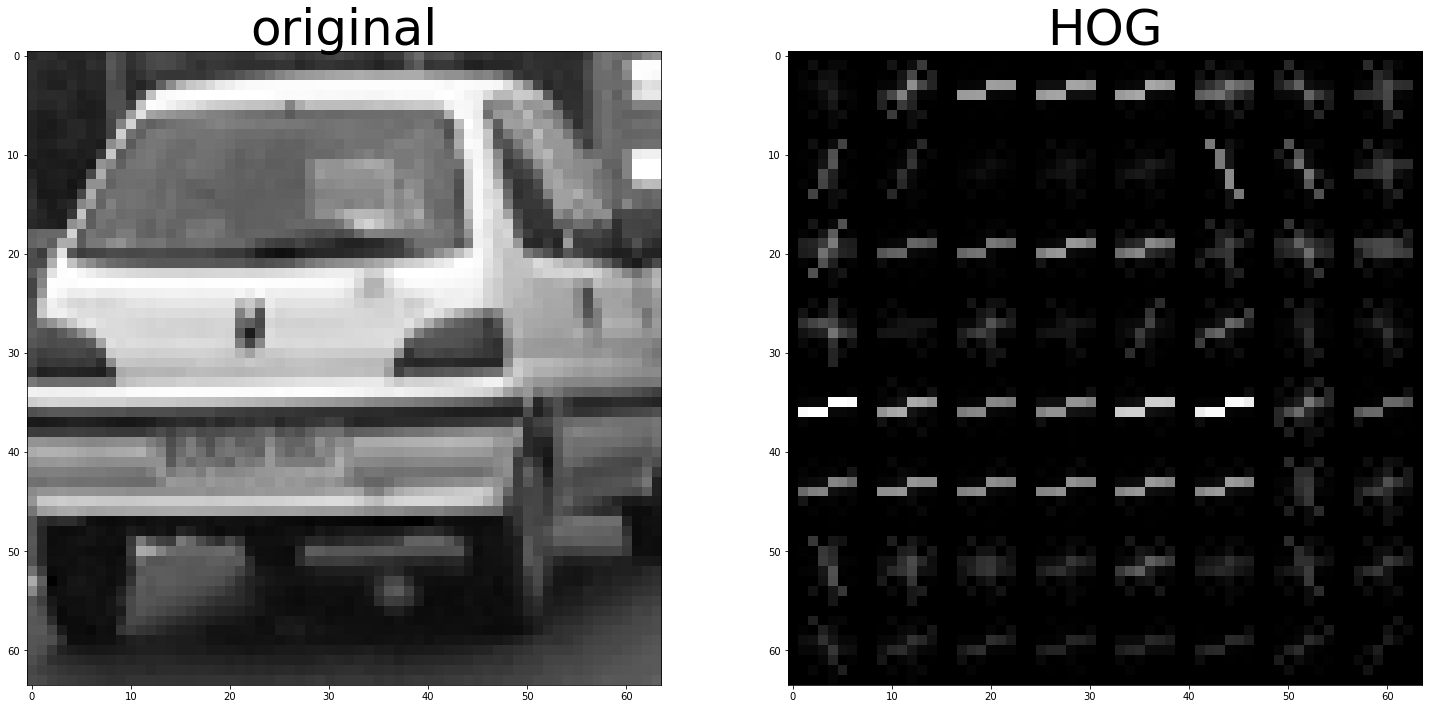

In [10]:
img = mpimg.imread(car_imgs[rand[0]])
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
test_features,hog_image = get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax.flat[0].imshow(img, cmap='gray')
ax.flat[0].set_title('original',fontsize=50)
ax.flat[1].imshow(hog_image, cmap='gray')
ax.flat[1].set_title('HOG',fontsize=50)

We probably do not need all the channels to make a distinctive set of data. We shall now explore which color space is the best. Since we do not have a definitive metrics with which to judge the performance, we shall use visual.

C:\Users\felix.ding\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
C:\Users\felix.ding\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:190: RuntimeWarning: invalid value encountered in remainder
  orientations, orientation_histogram)
C:\Users\felix.ding\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:17: RuntimeWarning: invalid value encountered in minimum
  out = np.minimum(out, 0.2)


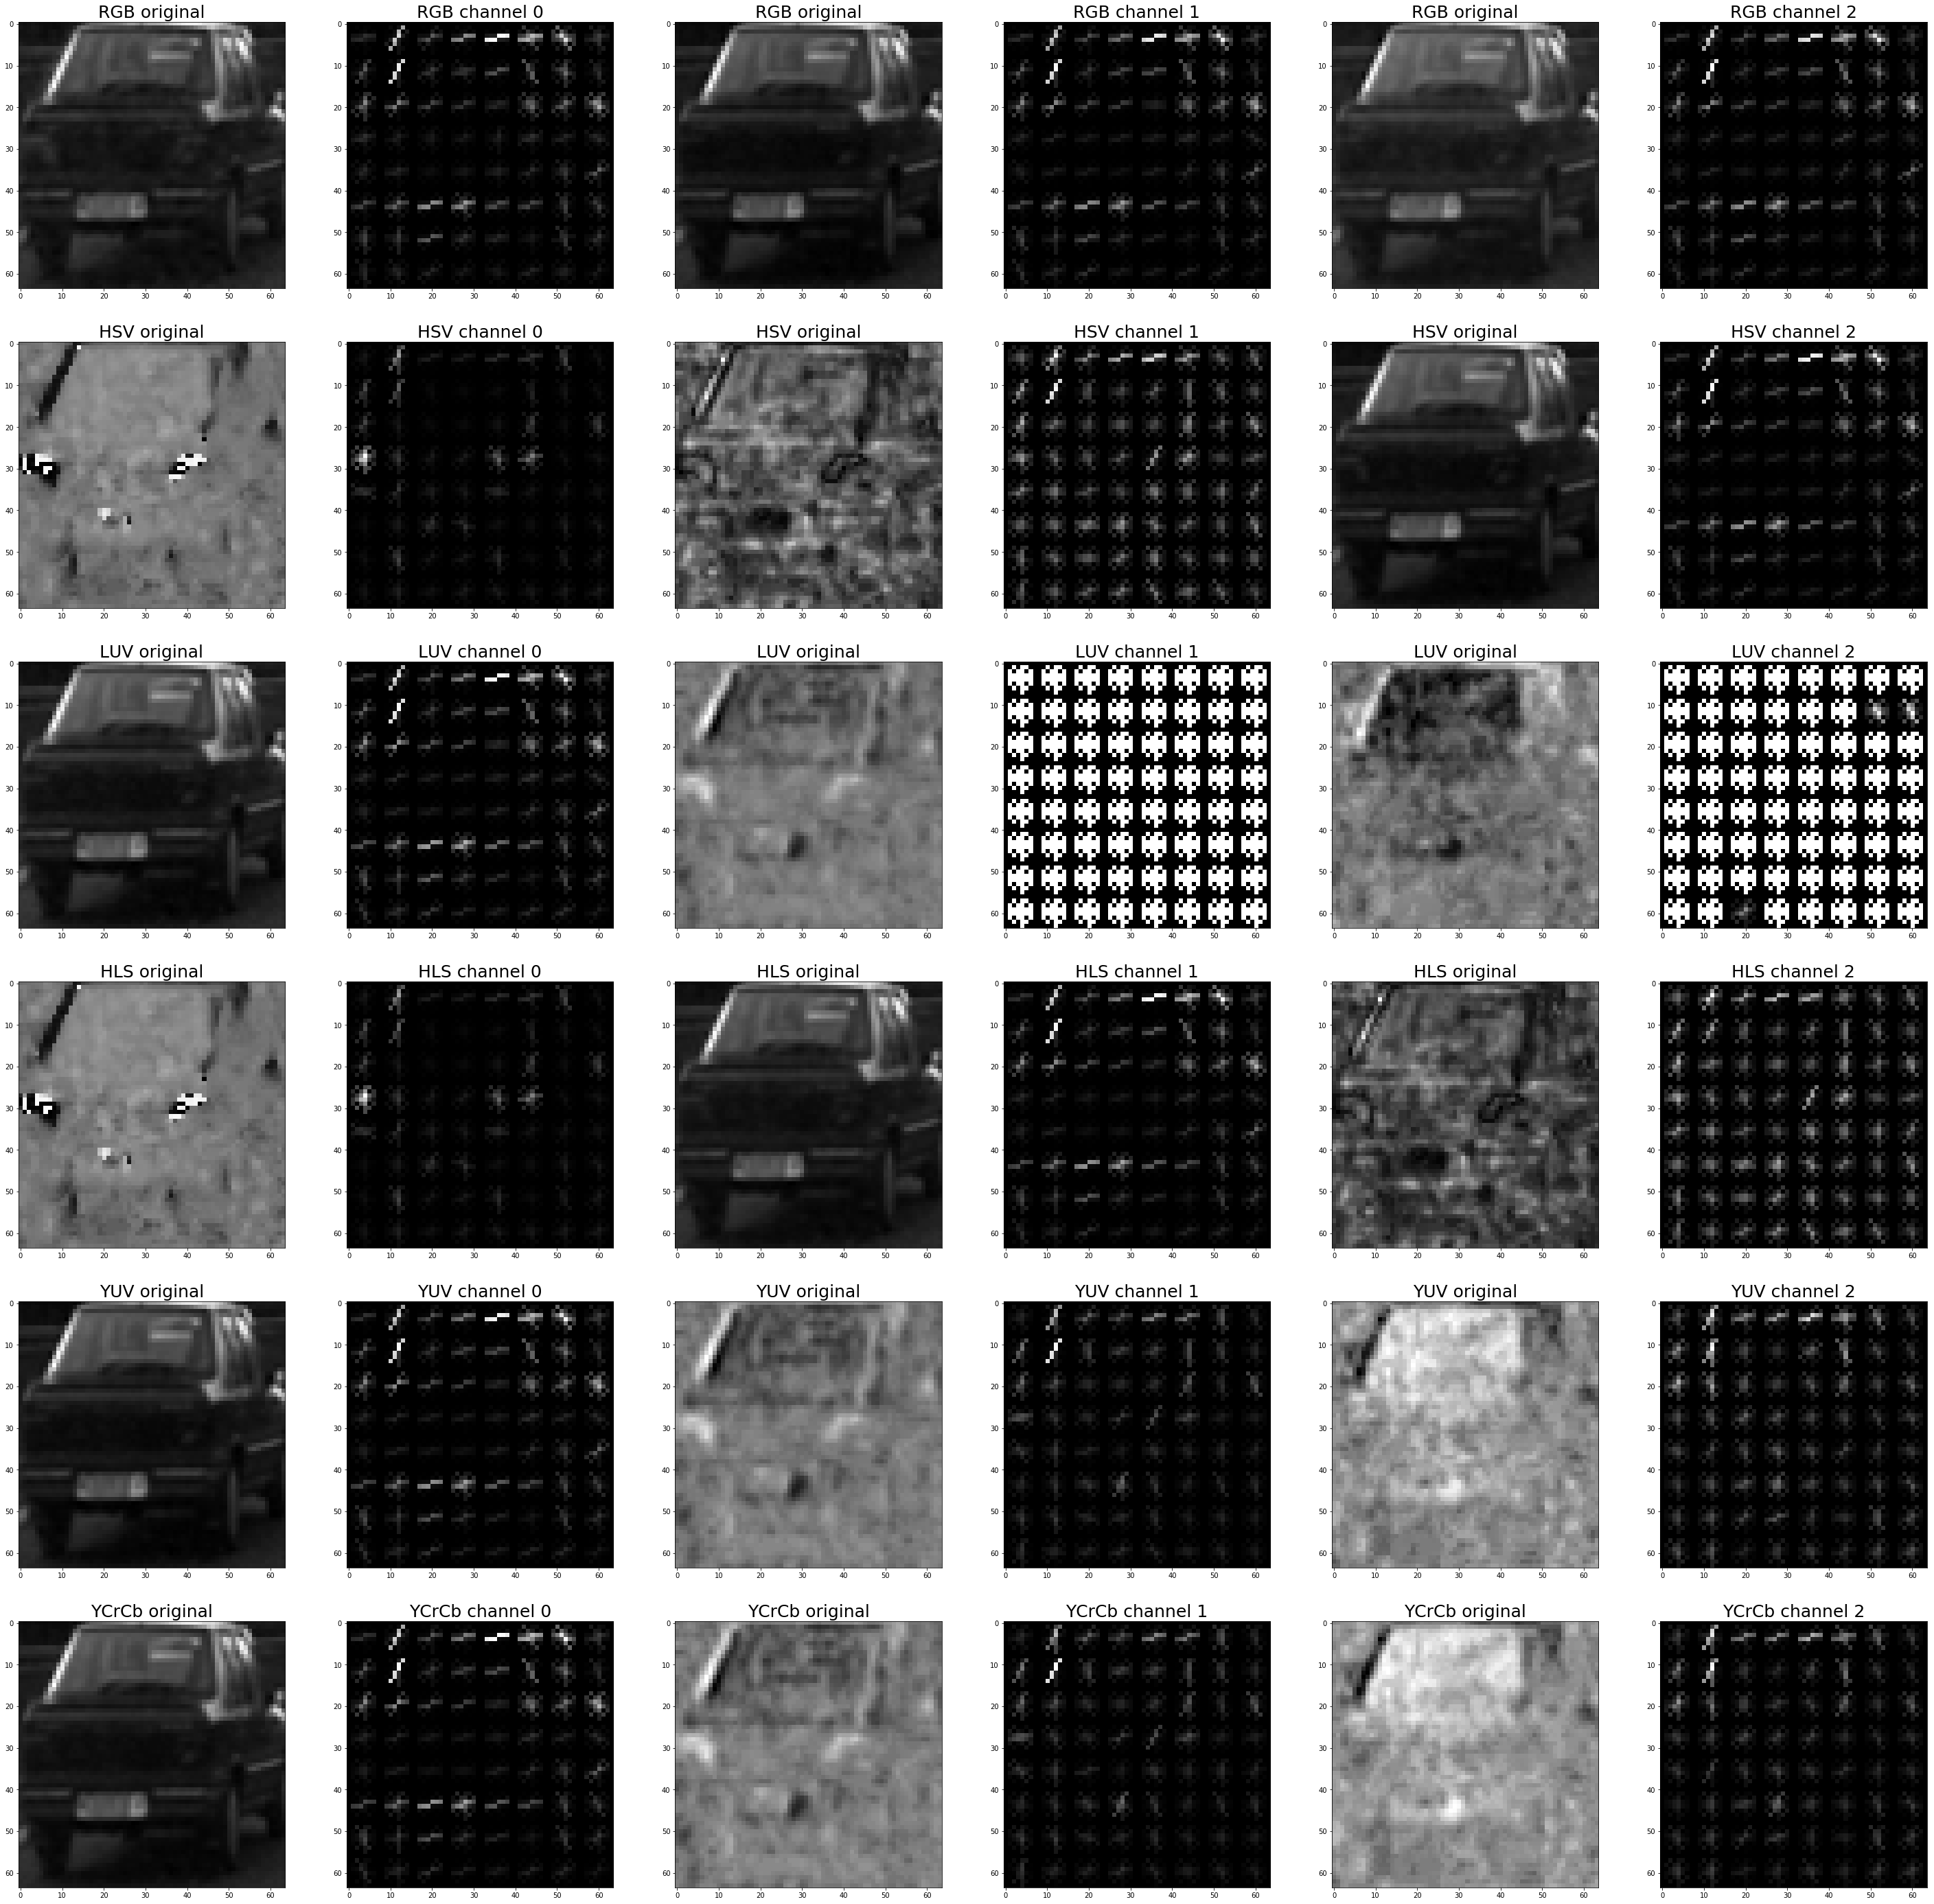

In [11]:
RGB = mpimg.imread(car_imgs[rand[5]])
HSV = cv2.cvtColor(RGB, cv2.COLOR_RGB2HSV)
LUV = cv2.cvtColor(RGB, cv2.COLOR_RGB2LUV)
HLS = cv2.cvtColor(RGB, cv2.COLOR_RGB2HLS)
YUV = cv2.cvtColor(RGB, cv2.COLOR_RGB2YUV)
YCrCb = cv2.cvtColor(RGB, cv2.COLOR_RGB2YCrCb)
cspace = [RGB, HSV, LUV, HLS, YUV, YCrCb]
cspace_names = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

fig, ax = plt.subplots(6,6,figsize=(50,50))
i=0
for img in cspace:
    test_features_0,hog_image_0 = get_hog_features(img[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    test_features_1,hog_image_1 = get_hog_features(img[:,:,1], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    test_features_2,hog_image_2 = get_hog_features(img[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    ax[i,0].imshow(img[:,:,0], cmap='gray')
    ax[i,0].set_title(cspace_names[i]+' original',fontsize=25)
    ax[i,1].imshow(hog_image_0, cmap='gray')
    ax[i,1].set_title(cspace_names[i]+' channel 0',fontsize=25)
    ax[i,2].imshow(img[:,:,1], cmap='gray')
    ax[i,2].set_title(cspace_names[i]+' original',fontsize=25)
    ax[i,3].imshow(hog_image_1, cmap='gray')
    ax[i,3].set_title(cspace_names[i]+' channel 1',fontsize=25)
    ax[i,4].imshow(img[:,:,2], cmap='gray')
    ax[i,4].set_title(cspace_names[i]+' original',fontsize=25)
    ax[i,5].imshow(hog_image_2, cmap='gray')
    ax[i,5].set_title(cspace_names[i]+' channel 2',fontsize=25)
    i += 1

It can be seen that there are a couple of options that can be ruled out immediately. These are the options that do not produce anything that resembles what is in the original image. These are:
* LUV channel 1
* LUV channel 2

Next, we eliminate those which do not produce a HOG that captures enough details or those which do not capture the correct direction of gradient that resembles the shape of the car:
* RGB channel 0
* HSV channel 0
* HSV channel 1
* HLS channel 0
* HLS channel 2
* YUV channel 1
* YUV channel 2
* YCrCb channel 1
* YCrCb channel 2

This leaves us with:
* RBG 1 and 2
* HSV 2
* LUV 0
* HLS 1
* YUV 0
* YCrCb 0

In [3]:
# add color hist to make classifier more robust
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
# add bin spatial
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [5]:
# define function to preprocess the image before using the hog function
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

Testing Extract Features Functions

In [ ]:
# choose 200 images
sample_number = 200
car_features = extract_features(car_imgs, cspace='LUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0)
noncar_features = extract_features(noncar_imgs, cspace='LUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0)
print(len(car_features))
print(len(noncar_features))

## Choose and Train a Classifier
### Steps to choosing and training a classifier:
1. Create labels
2. Preprocess data
3. Determine a combination of hyperparameters and optimize
4. Train

Create labels

In [ ]:
# create labels for the two sets of data
y = np.hstack((np.ones(len(car_imgs)),np.zeros(len(noncar_imgs))))

# create array stack of feature vectors
X = np.vstack((car_features,noncar_features)).astype(np.float64)

Preprocess data. This includes splitting, followed by scaling. 

In [ ]:
# Split data
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Scale data
X_scaler = StandardScaler().fit(X_train)
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

In [ ]:
print(X_train.shape)

Parameter Tuning using Scikit-learn Cross Validation.
The classifier chosen is SVM. 
There are three main parameters to tune for SVM:
1. Gamma: defines how far the influence of a single training example reaches (low value - far reaching, high value - close)
2. C: defines the tradeoff between smoothness of the decision boundary and the number of sample
3. Kernel: increase of input space to achieve a more linear separable data

In [ ]:
parameters = {'kernel':('linear','rbf'), 'C':[1,5,10]}
svr = svm.SVC()
clf = GridSearchCV(svr,parameters)
clf.fit(scaled_X_train, y_train)

In [ ]:
# verifying classifier accuracy
y_pred_test = clf.predict(scaled_X_test)
accuracy = accuracy_score(y_test, y_pred_test)
print('the classifier accuracy is: ', accuracy)

In [ ]:
# saving the classifier
f = open('trained_clf.p', 'wb')
pickle.dump(clf, f)
f.close()

95% accuracy may not be enough for this exercise (as learned previously from traffic sign identification project). As an attempt to improve this. The following approach is taken:
* Use a different color space for data prep
* Use all channel to increase data space
* Alter/increase the number of gradient directions in the HOG

In [15]:
# preparing a second set of data
car_features_2 = extract_features(car_imgs, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True)
noncar_features_2 = extract_features(noncar_imgs, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True)
print(len(car_features_2))
print(len(noncar_features_2))

8792
8968


In [16]:
# create labels for the two sets of data
y = np.hstack((np.ones(len(car_imgs)),np.zeros(len(noncar_imgs))))
# create array stack of feature vectors
X = np.vstack((car_features_2,noncar_features_2)).astype(np.float64)

# Split data
rand_state = np.random.randint(0, 100)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Scale data
X_scaler_2 = StandardScaler().fit(X_train_2)
scaled_X_train = X_scaler_2.transform(X_train_2)
scaled_X_test = X_scaler_2.transform(X_test_2)

In [17]:
# training a secondary classifier (shall be named clf2, using the optimized parameter tuned above)
from sklearn.svm import LinearSVC
clf3 = LinearSVC()
clf3.fit(scaled_X_train, y_train_2)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [18]:
# testing for accuracy
y_pred_test = clf3.predict(scaled_X_test)
accuracy = accuracy_score(y_test_2, y_pred_test)
print('the classifier accuracy is: ', accuracy)

the classifier accuracy is:  0.9828265765765766


As shown above, the secondary classifier has a much higher accuracy. Therefore, the secondary classifier should be used instead.

In [19]:
# saving the secondary classifier
f = open('trained_clf3.p', 'wb')
pickle.dump(clf3, f)
f.close()
f = open('X_scaler_2.p', 'wb')
pickle.dump(X_scaler_2, f)
f.close()

## Implement a Sliding Window Technique
### Steps to implementing the sliding window technique
1. Define start stop position for x and y for area of search
2. Define the sizes with which the windows will be created
3. Define overlap percentage for sliding window
4. Combine the detection with sliding window
5. Heat map to filter out false positive

In [6]:
# define sliding window function. This function returns a list of rectangle corner coordinates
def slide_window(img, x_start_stop=[None,None], y_start_stop=[None,None], xy_window=(64,64), xy_overlap=(0.5,0.5)):
    # process search area
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # define area
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # define number of window positions
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*xy_overlap[0])
    ny_buffer = np.int(xy_window[1]*xy_overlap[1])
    nx_window = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_window = np.int((yspan-ny_buffer)/nx_pix_per_step)
    # define end points of rectangles
    window_list = []
    # cycle through every window position
    for ys in range(ny_window):
        for xs in range(nx_window):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endx = startx + xy_window[0]
            endy = starty + xy_window[1]
            window_list.append(((startx,starty),(endx,endy)))
    return window_list

In [7]:
# define a function that draws rectangle
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

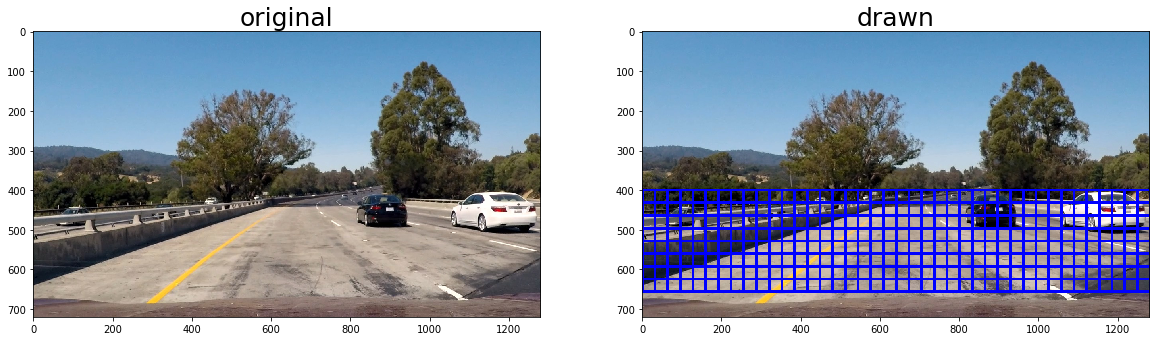

In [8]:
# testing the two functions together
img_test = mpimg.imread('test_images/test1.jpg')
y_start_stop = [400, 670]
xy_window = ()
window_test = slide_window(img_test,y_start_stop=y_start_stop)
output_test = draw_boxes(img_test, window_test)
fig, ax = plt.subplots(1,2,figsize=(20,20))
ax.flat[0].imshow(img_test)
ax.flat[0].set_title('original',fontsize=25)
ax.flat[1].imshow(output_test)
ax.flat[1].set_title('drawn',fontsize=25)

### Combine object detection with sliding window

In [9]:
# first, we need to redefine the feature extraction function so that it finds features from one image:
def single_img_features(img, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    image = img.astype(np.float32)/255
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)

    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], orient, 
                                                 pix_per_cell, cell_per_block, vis=False, feature_vec=False))
        hog_features = np.ravel(hog_features)
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                        pix_per_cell, cell_per_block, vis=False, feature_vec=False)

    return hog_features

In [10]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [13]:
# define an a still image pipeline for finding cars
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    rectangles = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                if vis == True:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                    
    if vis == True:
        return draw_img, rectangles
    else:
        return rectangles

In [14]:
ystart = 400
ystop = 650
scale = 1.5
svc = clf3
X_scaler = X_scaler_2
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size=(32, 32)
hist_bins=32

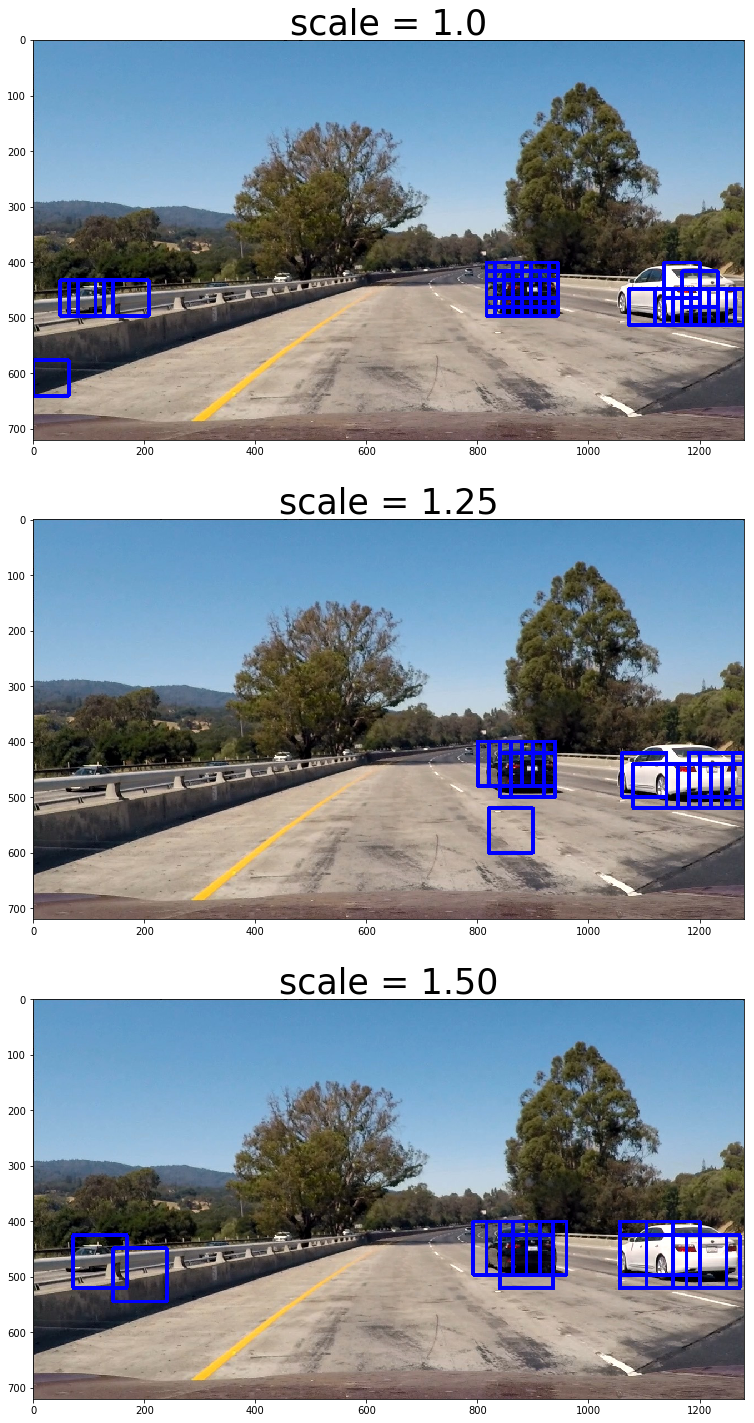

In [26]:
img = mpimg.imread('test_images/test1.jpg')

detection_1, win1 = find_cars(img, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=True)
detection_2, win2 = find_cars(img, ystart, ystop, 1.25, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=True)
detection_3, win3 = find_cars(img, ystart, ystop, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=True)

# plot
fig, ax = plt.subplots(3,1,figsize=(25,25))
ax.flat[0].imshow(detection_1)
ax.flat[0].set_title('scale = 1.0',fontsize=35)
ax.flat[1].imshow(detection_2)
ax.flat[1].set_title('scale = 1.25',fontsize=35)
ax.flat[2].imshow(detection_3)
ax.flat[2].set_title('scale = 1.50',fontsize=35)

### Add in a heat map to filter out false positives
#### steps to adding heat map filter:
1. Take a zero data image of identical size to the video frame, add 1 for each time the region is confirmed positive
2. Apply a threshold to filter everything that is below the threshold
3. Use label function to determine the number of cars found
4. Redraw boxes on region that are above the threshold

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

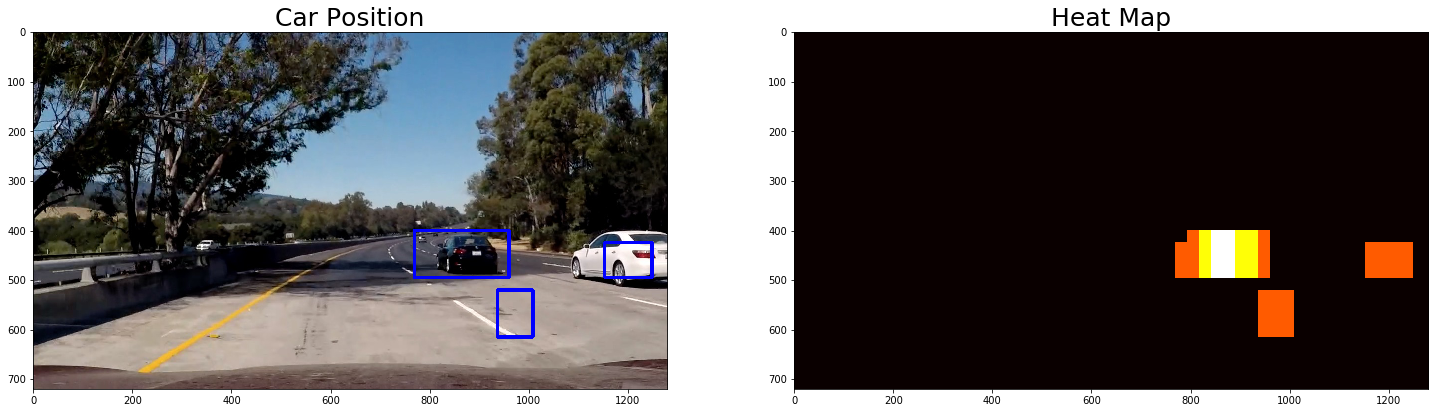

In [18]:
# testing heat map filter on the image above
# storing the positive points in an array
box_list = win
heat = np.zeros_like(img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# visualize
fig, ax = plt.subplots(1,2, figsize=(25,25))
ax.flat[0].imshow(draw_img)
ax.flat[0].set_title('Car Position',fontsize=25)
ax.flat[1].imshow(heatmap, cmap='hot')
ax.flat[1].set_title('Heat Map', fontsize=25)

## Implement pipeline on video

In [12]:
# load in classifier
import pickle
f = open('trained_clf3.p', 'rb')
g = open('X_scaler_2.p', 'rb')
clf3 = pickle.load(f)
X_scaler_2 = pickle.load(g)
f.close()
g.close()

In [22]:
# a final pipeline to tie everything together to produce a processed, color image
from collections import deque
def process_image(img):
    # obtain possible matches with different scales
    scale = [1, 1.25, 1.5, 1.75, 2.0]
    win1 = find_cars(img, ystart, ystop, scale[0], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    win2 = find_cars(img, ystart, ystop, scale[1], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    win3 = find_cars(img, ystart, ystop, scale[2], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    win4 = find_cars(img, ystart, ystop, scale[3], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    win5 = find_cars(img, ystart, ystop, scale[4], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bbox_list = np.concatenate((win1, win2, win3, win4, win5))
    # create heat map to later use as a filter to eliminate false positives
    heatmap = np.zeros_like(img[:,:,0])
    heat = add_heat(heatmap,bbox_list)
    #heat = np.clip(heat, 0, 255)
    # store up to last 8 frames and average
    history.append(heat)
    heat_avg = (np.sum(history,axis=0))/len(history)
    heat_avg = apply_threshold(heat_avg, 20)
    labels = label(heat_avg)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [23]:
ystart = 400
ystop = 650
# scale = 1.5
svc = clf3
X_scaler = X_scaler_2
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size=(32, 32)
hist_bins=32

In [24]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
history = deque(maxlen=8)
# create a Line instance for left and right line:
white_output = "test_video_processed.mp4"
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_processed.mp4
[MoviePy] Writing video test_video_processed.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [03:09<00:04,  4.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_processed.mp4 

Wall time: 3min 10s
